# Step-by-step on  **Unsupervised Learning Trading Strategy**

- Unduh/Data Harga Saham SP500: Ambil data harga saham untuk indeks S&P 500.
- Hitung Fitur dan Indikator: Hitung berbagai fitur dan indikator untuk setiap saham.
- Agregasi dan Filter: Agregasi data secara bulanan dan pilih 150 saham paling likuid.
- Hitung Pengembalian Bulanan: Hitung pengembalian bulanan untuk berbagai periode waktu.
- Unduh Faktor Fama-French dan Hitung Beta Faktor: Ambil faktor Fama-French dan hitung beta faktor secara rolling.
- K-Means Clustering Bulanan: Terapkan algoritma K-Means Clustering setiap bulan untuk mengelompokkan aset serupa berdasarkan fitur mereka.
- Bentuk Portofolio: Pilih aset berdasarkan cluster dan bentuk portofolio dengan optimisasi rasio Sharpe maksimum di Frontier Efisien.
- Visualisasi dan Perbandingan: Visualisasikan pengembalian portofolio dan bandingkan dengan pengembalian S&P 500.

*eng*
- Download/Load SP500 Stocks Prices Data: Retrieve stock price data for the S&P 500 index.
- Calculate Features and Indicators: Compute various features and indicators for each stock.
- Aggregate and Filter: Aggregate data on a monthly basis and select the top 150 most liquid stocks.
- Calculate Monthly Returns: Determine monthly returns for different time horizons.
- Download Fama-French Factors and Calculate Rolling Factor Betas: Obtain Fama-French factors and calculate rolling betas for these factors.
- Monthly K-Means Clustering: Apply the K-Means Clustering algorithm each month to group similar assets based on their features.
- Construct Portfolio: Select assets based on clusters and form a portfolio using maximum Sharpe ratio optimization on the Efficient Frontier.
- Visualize and Compare: Visualize the portfolio returns and compare them with S&P 500 returns.

# Packages Needed:
* pandas, numpy, matplotlib, statsmodels, pandas_datareader, datetime, yfinance, sklearn, PyPortfolioOpt


## 1. Download/Load SP500 stocks prices data

In [33]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
warnings.filterwarnings('ignore')

sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')

symbols_list = sp500['Symbol'].unique().tolist()

# Define the end date
end_date = "2024-08-25"

# Start date on 8 years prior to the end date
start_date = pd.to_datetime(end_date)-pd.DateOffset(365*8)


# Using yfinance lib to download the price data
df = yf.download(tickers=symbols_list,
                 start=start_date,
                 end=end_date).stack()

df.index.names = ['date', 'ticker']

df.columns = df.columns.str.lower()

df

[*********************100%%**********************]  503 of 503 completed


Price               adj close       close        high         low        open  \
date       ticker                                                               
2016-08-29 A        44.720501   47.619999   47.889999   47.310001   47.450001   
           AAL      34.864246   36.169998   36.410000   36.049999   36.130001   
           AAPL     24.632547   26.705000   26.860001   26.572500   26.655001   
           ABBV     45.698769   64.510002   65.089996   64.190002   64.839996   
           ABT      37.360985   43.250000   43.570000   42.950001   43.000000   
...                       ...         ...         ...         ...         ...   
2024-08-23 XYL     136.557083  136.919998  137.529999  135.539993  136.399994   
           YUM     134.847168  135.520004  137.410004  134.949997  137.410004   
           ZBH     115.050003  115.050003  115.339996  113.559998  114.000000   
           ZBRA    351.619995  351.619995  351.790009  344.170013  344.170013   
           ZTS     180.899994  180.899994  182.940002  180.179993  182.860001   

Price                  volume  
date       ticker              
2016-08-29 A        1333000.0  
           AAL      4760700.0  
           AAPL    99881200.0  
           ABBV     5099200.0  
           ABT      9223200.0  
...                       ...  
2024-08-23 XYL       693100.0  
           YUM      1657800.0  
           ZBH       788400.0  
           ZBRA      196300.0  
           ZTS      1262400.0  

[990246 rows x 6 columns]

## 2. Calculate features and technical indicators for each stock.

* **Garman-Klass Volatility**
\begin{equation}
\text{Garman-Klass Volatility} = \frac{(\ln(\text{High}) - \ln(\text{Low}))^2}{2} - (2\ln(2) - 1)(\ln(\text{Adj Close}) - \ln(\text{Open}))^2
\end{equation}
* **RSI**
\begin{equation}
\text{RSI} = 100 - \frac{100}{1 + \text{RS}}
\end{equation}
Where RS (Relative Strength) is:
\begin{equation}
\text{RS} = \frac{\text{Average Gain}}{\text{Average Loss}}
\end{equation}
* **Bollinger Bands**
\begin{equation}
\begin{aligned}
\text{Middle Band} &= \text{SMA}(n) \
\text{Upper Band} &= \text{SMA}(n) + k \times \sigma \
\text{Lower Band} &= \text{SMA}(n) - k \times \sigma
\end{aligned}
\end{equation}
Where:
1. SMA(n) is the Simple Moving Average over n periods
2. σ is the standard deviation of the last n periods
3. k is the number of standard deviations (typically 2)
* **ATR**
\begin{equation}
\text{TR} = \max((\text{High} - \text{Low}), |\text{High} - \text{Close}\text{prev}|, |\text{Low} - \text{Close}\text{prev}|)
\end{equation}
\begin{equation}
\text{ATR} = \frac{\text{ATR}_\text{prev} \times (n-1) + \text{TR}}{n}
\end{equation}
Where n is the number of periods (typically 14)
* **MACD**
\begin{equation}
\begin{aligned}
\text{MACD Line} &= \text{EMA}(12) - \text{EMA}(26) \
\text{Signal Line} &= \text{EMA}(9) \text{ of MACD Line} \
\text{MACD Histogram} &= \text{MACD Line} - \text{Signal Line}
\end{aligned}
\end{equation}
Where EMA(n) is the Exponential Moving Average over n periods
* **Dollar Volume**
\begin{equation}
\text{Dollar Volume} = \text{Price} \times \text{Volume}
\end{equation}

In [34]:
df['garman_klass_vol'] = ((np.log(df['high'])-np.log(df['low']))**2)/2-(2*np.log(2)-1)*((np.log(df['adj close'])-np.log(df['open']))**2)

df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))

df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])
                                                          
df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,1])
                                                          
df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,2])

def compute_atr(stock_data):
    atr = pandas_ta.atr(high=stock_data['high'],
                        low=stock_data['low'],
                        close=stock_data['close'],
                        length=14)
    return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)

def compute_macd(close):
    macd = pandas_ta.macd(close=close, length=20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())

df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)

df['dollar_volume'] = ((df['adj close'] * df['volume']) / 1e6)

df

Price               adj close       close        high         low        open  \
date       ticker                                                               
2016-08-29 A        44.720501   47.619999   47.889999   47.310001   47.450001   
           AAL      34.864246   36.169998   36.410000   36.049999   36.130001   
           AAPL     24.632547   26.705000   26.860001   26.572500   26.655001   
           ABBV     45.698769   64.510002   65.089996   64.190002   64.839996   
           ABT      37.360985   43.250000   43.570000   42.950001   43.000000   
...                       ...         ...         ...         ...         ...   
2024-08-23 XYL     136.557083  136.919998  137.529999  135.539993  136.399994   
           YUM     134.847168  135.520004  137.410004  134.949997  137.410004   
           ZBH     115.050003  115.050003  115.339996  113.559998  114.000000   
           ZBRA    351.619995  351.619995  351.790009  344.170013  344.170013   
           ZTS     180.899994  180.899994  182.940002  180.179993  182.860001   

Price                  volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2016-08-29 A        1333000.0         -0.001282        NaN       NaN   
           AAL      4760700.0         -0.000442        NaN       NaN   
           AAPL    99881200.0         -0.002347        NaN       NaN   
           ABBV     5099200.0         -0.047184        NaN       NaN   
           ABT      9223200.0         -0.007531        NaN       NaN   
...                       ...               ...        ...       ...   
2024-08-23 XYL       693100.0          0.000106  54.623804  4.831236   
           YUM      1657800.0          0.000026  52.772536  4.883194   
           ZBH       788400.0          0.000088  60.502375  4.671524   
           ZBRA      196300.0          0.000063  62.613871  5.740276   
           ZTS      1262400.0          0.000071  50.617980  5.184141   

Price                bb_mid   bb_high       atr      macd  dollar_volume  
date       ticker                                                         
2016-08-29 A            NaN       NaN       NaN       NaN      59.612428  
           AAL          NaN       NaN       NaN       NaN     165.978218  
           AAPL         NaN       NaN       NaN       NaN    2460.328391  
           ABBV         NaN       NaN       NaN       NaN     233.027161  
           ABT          NaN       NaN       NaN       NaN     344.587835  
...                     ...       ...       ...       ...            ...  
2024-08-23 XYL     4.888295  4.945354  1.036257 -0.189674      94.647714  
           YUM     4.913084  4.942975  0.598046  0.785863     223.549635  
           ZBH     4.710996  4.750469 -0.642132  0.403894      90.705422  
           ZBRA    5.815471  5.890665  0.367880  0.716705      69.023005  
           ZTS     5.215506  5.246871  0.705971  0.272652     228.368152  

[990246 rows x 14 columns]

## 3. Aggregate to monthly level and filter top 150 most liquid stocks for each month

* To reduce training time and experiment with features and strategies, we convert the business-daily data to month-end frequency.

In [35]:

# Define the order of the columns
desired_order = ['dollar_volume', 'adj close', 'atr', 'bb_high', 'bb_low', 'bb_mid', 'garman_klass_vol', 'macd', 'rsi']

last_cols = [c for c in df.columns.unique(0) if c not in ['volume', 'open',
                                                          'high', 'low', 'close']]

data = df.unstack()[last_cols].resample('M').last().stack('ticker').dropna()

data = data[desired_order]

data    

Price              dollar_volume   adj close       atr   bb_high    bb_low  \
date       ticker                                                            
2016-10-31 A           63.857977   41.018742 -1.349695  3.839099  3.718486   
           AAL        233.283682   39.134335  0.639149  3.706314  3.604673   
           AAPL      2766.868577   26.182167 -1.269915  3.350880  3.293123   
           ABBV       565.712565   39.878792 -1.048458  3.852822  3.744517   
           ABT        281.144828   34.112480 -1.245244  3.650426  3.549492   
...                          ...         ...       ...       ...       ...   
2024-08-31 XYL         94.647714  136.557083  1.036257  4.945354  4.831236   
           YUM        223.549635  134.847168  0.598046  4.942975  4.883194   
           ZBH         90.705422  115.050003 -0.642132  4.750469  4.671524   
           ZBRA        69.023005  351.619995  0.367880  5.890665  5.740276   
           ZTS        228.368152  180.899994  0.705971  5.246871  5.184141   

Price                bb_mid  garman_klass_vol      macd        rsi  
date       ticker                                                   
2016-10-31 A       3.778792         -0.001089 -0.534874  35.933850  
           AAL     3.655494         -0.000176  1.122970  62.786104  
           AAPL    3.322002         -0.002541 -0.218850  49.022076  
           ABBV    3.798670         -0.049190 -0.709314  26.094613  
           ABT     3.599959         -0.008074 -0.573996  37.005100  
...                     ...               ...       ...        ...  
2024-08-31 XYL     4.888295          0.000106 -0.189674  54.623804  
           YUM     4.913084          0.000026  0.785863  52.772536  
           ZBH     4.710996          0.000088  0.403894  60.502375  
           ZBRA    5.815471          0.000063  0.716705  62.613871  
           ZTS     5.215506          0.000071  0.272652  50.617980  

[46801 rows x 9 columns]

* Calculate 5-year rolling average of dollar volume for each stocks before filtering.

In [36]:
data['dollar_volume'] = (data.loc[:, 'dollar_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack())

data['dollar_vol_rank'] = (data.groupby('date')['dollar_volume'].rank(ascending=False))

data = data[data['dollar_vol_rank']<150].drop(['dollar_volume', 'dollar_vol_rank'], axis=1)

data

Price               adj close       atr   bb_high    bb_low    bb_mid  \
date       ticker                                                       
2017-09-30 AAL      46.185772  0.696079  3.876266  3.764262  3.820264   
           AAPL     36.166767 -1.140634  3.684699  3.589136  3.636917   
           ABBV     65.390602 -0.449862  4.254232  4.050517  4.152374   
           ABT      47.232563 -1.169962  3.877438  3.825775  3.851606   
           ACN     121.064735 -1.112030  4.841457  4.770444  4.805951   
...                       ...       ...       ...       ...       ...   
2024-08-31 VZ       41.209999 -0.688468  3.745912  3.709242  3.727577   
           WFC      56.700001  0.719906  4.109822  3.933198  4.021510   
           WMT      75.699997  2.006673  4.353373  4.180950  4.267162   
           XOM     116.320000  0.643992  4.793701  4.736064  4.764882   
           ZTS     180.899994  0.705971  5.246871  5.184141  5.215506   

Price              garman_klass_vol      macd        rsi  
date       ticker                                         
2017-09-30 AAL            -0.000215  0.384056  53.050774  
           AAPL           -0.001175 -0.457125  45.768839  
           ABBV           -0.035700  1.050891  70.568570  
           ABT            -0.006208  0.341548  63.665014  
           ACN            -0.005643  0.170581  56.250011  
...                             ...       ...        ...  
2024-08-31 VZ              0.000017  0.284574  55.297766  
           WFC             0.000171 -0.520343  51.523136  
           WMT             0.000056  3.009412  72.371036  
           XOM             0.000058  0.118687  52.049330  
           ZTS             0.000071  0.272652  50.617980  

[12516 rows x 8 columns]

## 4. Calculate Monthly Returns for different time horizons as features.

* To capture time series dynamics that reflect, for example, momentum patterns, we compute historical returns using the method *.pct_change(lag)*, that is, **returns over various monthly periods as identified by lags**.

In [37]:
def calculate_returns(df):

    outlier_cutoff = 0.005

    lags = [1, 2, 3, 6, 9, 12]

    for lag in lags:

        df[f'return_{lag}m'] = (df['adj close']
                              .pct_change(lag)
                              .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                     upper=x.quantile(1-outlier_cutoff)))
                              .add(1)
                              .pow(1/lag)
                              .sub(1)) 
    return df
    
    
data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()

data

Price               adj close       atr   bb_high    bb_low    bb_mid  \
date       ticker                                                       
2018-09-30 AAL      40.560379  0.610564  3.767176  3.648527  3.707851   
           AAPL     53.774525 -0.871153  4.018120  3.958415  3.988268   
           ABBV     72.047661 -0.681599  4.312119  4.257714  4.284917   
           ABT      66.177353 -1.083182  4.211202  4.073479  4.142340   
           ACN     155.388901 -1.072014  5.077972  5.037983  5.057977   
...                       ...       ...       ...       ...       ...   
2024-08-31 VRTX    481.239990  1.503814  6.230200  6.125789  6.177994   
           VZ       41.209999 -0.688468  3.745912  3.709242  3.727577   
           WFC      56.700001  0.719906  4.109822  3.933198  4.021510   
           WMT      75.699997  2.006673  4.353373  4.180950  4.267162   
           XOM     116.320000  0.643992  4.793701  4.736064  4.764882   

Price              garman_klass_vol      macd        rsi  return_1m  \
date       ticker                                                     
2018-09-30 AAL             0.000314  0.916478  54.647855   0.020998   
           AAPL           -0.000718 -0.051123  61.186112  -0.008303   
           ABBV           -0.027228 -0.468568  49.718816  -0.014587   
           ABT            -0.003433  1.176182  79.127187   0.097547   
           ACN            -0.003063  0.140384  54.490795   0.006684   
...                             ...       ...        ...        ...   
2024-08-31 VRTX            0.000064 -0.397739  51.571284  -0.029210   
           VZ              0.000017  0.284574  55.297766   0.017029   
           WFC             0.000171 -0.520343  51.523136  -0.037190   
           WMT             0.000056  3.009412  72.371036   0.105999   
           XOM             0.000058  0.118687  52.049330  -0.011245   

Price              return_2m  return_3m  return_6m  return_9m  return_12m  
date       ticker                                                          
2018-09-30 AAL      0.023718   0.029652  -0.036636  -0.024513   -0.010765  
           AAPL     0.091080   0.069629   0.051986   0.033843    0.033607  
           ABBV     0.012660   0.010312   0.003293   0.000594    0.008112  
           ABT      0.057978   0.065081   0.035905   0.029900    0.028503  
           ACN      0.033549   0.013291   0.018852   0.012830    0.021018  
...                      ...        ...        ...        ...         ...  
2024-08-31 VRTX     0.013267   0.018612   0.022644   0.034445    0.027298  
           VZ       0.007783   0.005914   0.010319   0.013588    0.019695  
           WFC     -0.019184  -0.015750   0.005534   0.029380    0.029285  
           WMT      0.058863   0.049035   0.045257   0.043198    0.028227  
           XOM      0.009237  -0.000010   0.020724   0.016750    0.006653  

[10330 rows x 14 columns]

## 5. Download Fama-French Factors and Calculate Rolling Factor Betas.

* We will introduce the Fama—French data to estimate the exposure of assets to common risk factors using linear regression.

* The five Fama—French factors, namely market risk, size, value, operating profitability, and investment have been shown empirically to explain asset returns and are commonly used to assess the risk/return profile of portfolios. Hence, it is natural to include past factor exposures as financial features in models.

* We can access the historical factor returns using the pandas-datareader and estimate historical exposures using the RollingOLS rolling linear regression.

* see the fama-french factor on <https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html>


In [38]:
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
                               'famafrench',
                               start='2010')[0].drop('RF', axis=1)

factor_data.index = factor_data.index.to_timestamp()

factor_data = factor_data.resample('M').last().div(100)

factor_data.index.name = 'date'

# beginning month we have the factors, and we have the return_1m for the end of the month
factor_data = factor_data.join(data['return_1m']).sort_index()

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2018-09-30 AAL     0.0006 -0.0249 -0.0171  0.0063  0.0129   0.020998
           AAPL    0.0006 -0.0249 -0.0171  0.0063  0.0129  -0.008303
           ABBV    0.0006 -0.0249 -0.0171  0.0063  0.0129  -0.014587
           ABT     0.0006 -0.0249 -0.0171  0.0063  0.0129   0.097547
           ACN     0.0006 -0.0249 -0.0171  0.0063  0.0129   0.006684
...                   ...     ...     ...     ...     ...        ...
2024-07-31 VRTX    0.0124  0.0833  0.0570  0.0017  0.0043   0.057604
           VZ      0.0124  0.0833  0.0570  0.0017  0.0043  -0.001379
           WFC     0.0124  0.0833  0.0570  0.0017  0.0043  -0.000842
           WMT     0.0124  0.0833  0.0570  0.0017  0.0043   0.013735
           XOM     0.0124  0.0833  0.0570  0.0017  0.0043   0.030142

[10188 rows x 6 columns]

* Filter out stocks with less than 10 months of data.

In [9]:
# size means each month
observations = factor_data.groupby(level=1).size()

valid_stocks = observations[observations >= 10]

factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2020-09-30 AAL    -0.0363 -0.0005 -0.0265 -0.0128 -0.0196  -0.058238
           AAPL   -0.0363 -0.0005 -0.0265 -0.0128 -0.0196  -0.102526
           ABBV   -0.0363 -0.0005 -0.0265 -0.0128 -0.0196  -0.085413
           ABT    -0.0363 -0.0005 -0.0265 -0.0128 -0.0196  -0.005846
           ACN    -0.0363 -0.0005 -0.0265 -0.0128 -0.0196  -0.058100
...                   ...     ...     ...     ...     ...        ...
2024-07-31 VRTX    0.0124  0.0833  0.0570  0.0017  0.0043   0.057604
           VZ      0.0124  0.0833  0.0570  0.0017  0.0043  -0.001379
           WFC     0.0124  0.0833  0.0570  0.0017  0.0043  -0.000842
           WMT     0.0124  0.0833  0.0570  0.0017  0.0043   0.013735
           XOM     0.0124  0.0833  0.0570  0.0017  0.0043   0.030142

[6226 rows x 6 columns]

* Calculate Rolling Factor Betas.

In [10]:
betas = (factor_data.groupby(level=1,
                            group_keys=False)
         .apply(lambda x: RollingOLS(endog=x['return_1m'], 
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(24, x.shape[0]),
                                     min_nobs=len(x.columns)+1)
         .fit(params_only=True)
         .params
         .drop('const', axis=1)))

betas 

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2020-09-30 AAL          NaN       NaN       NaN       NaN       NaN
           AAPL         NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ACN          NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2024-07-31 VRTX    0.569025  0.648189 -0.392910  0.648667  0.140270
           VZ      0.690918 -0.857154  0.635281  0.286512 -0.472927
           WFC     1.111663 -0.130669  1.182283 -0.816393 -0.613399
           WMT     0.476279  0.121075 -0.163776  0.864053  0.098297
           XOM     0.635112 -0.090572  0.298959  0.612023  1.052172

[6226 rows x 5 columns]

* Join the rolling factors data to the main features dataframe.

In [11]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

data = (data.join(betas.groupby('ticker').shift()))

data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))

data = data.drop('adj close', axis=1)

data = data.dropna()

data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 6203 entries, (Timestamp('2020-09-30 00:00:00'), 'AAL') to (Timestamp('2024-08-31 00:00:00'), 'XOM')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   atr               6203 non-null   float64
 1   bb_high           6203 non-null   float64
 2   bb_low            6203 non-null   float64
 3   bb_mid            6203 non-null   float64
 4   garman_klass_vol  6203 non-null   float64
 5   macd              6203 non-null   float64
 6   rsi               6203 non-null   float64
 7   return_1m         6203 non-null   float64
 8   return_2m         6203 non-null   float64
 9   return_3m         6203 non-null   float64
 10  return_6m         6203 non-null   float64
 11  return_9m         6203 non-null   float64
 12  return_12m        6203 non-null   float64
 13  Mkt-RF            6203 non-null   float64
 14  SMB               6203 non-null   float64
 15  HML         

**At this point we have to decide on what ML model and approach to use for predictions etc.**

## 6. For each month fit a K-Means Clustering Algorithm to group similar assets based on their features.

### K-Means Clustering
* You may want to initialize predefined centroids for each cluster based on your research.

* For visualization purpose of this tutorial we will initially rely on the ‘k-means++’ initialization.

* Then we will pre-define our centroids for each cluster.

In [22]:
from sklearn.cluster import KMeans

data = data.drop('cluster', axis=1)

def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=4,
                           random_state=0,
                           init=initial_centroids).fit(df).labels_
    return df

data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)

data

atr   bb_high    bb_low    bb_mid  garman_klass_vol  \
date       ticker                                                             
2020-09-30 AAL    -0.527945  2.716906  2.542827  2.629867          0.001549   
           AAPL    1.472812  4.814457  4.630620  4.722538          0.000486   
           ABBV   -0.632262  4.385611  4.294652  4.340131         -0.009641   
           ABT     1.100716  4.632468  4.559131  4.595799         -0.000135   
           ACN     0.568331  5.468968  5.324847  5.396908         -0.001003   
...                     ...       ...       ...       ...               ...   
2024-08-31 VRTX    1.503814  6.230200  6.125789  6.177994          0.000064   
           VZ     -0.688468  3.745912  3.709242  3.727577          0.000017   
           WFC     0.719906  4.109822  3.933198  4.021510          0.000171   
           WMT     2.006673  4.353373  4.180950  4.267162          0.000056   
           XOM     0.643992  4.793701  4.736064  4.764882          0.000058   

                       macd        rsi  return_1m  return_2m  return_3m  \
date       ticker                                                         
2020-09-30 AAL    -0.129194  46.563822  -0.058238   0.051292  -0.020302   
           AAPL   -0.588851  53.282716  -0.102526   0.044911   0.083539   
           ABBV   -1.117209  39.882013  -0.085413  -0.039337  -0.033430   
           ABT     0.236405  58.959792  -0.005846   0.039894   0.061160   
           ACN    -0.868792  46.602643  -0.058100   0.002688   0.018439   
...                     ...        ...        ...        ...        ...   
2024-08-31 VRTX   -0.397739  51.571284  -0.029210   0.013267   0.018612   
           VZ      0.284574  55.297766   0.017029   0.007783   0.005914   
           WFC    -0.520343  51.523136  -0.037190  -0.019184  -0.015750   
           WMT     3.009412  72.371036   0.105999   0.058863   0.049035   
           XOM     0.118687  52.049330  -0.011245   0.009237  -0.000010   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2020-09-30 AAL      0.001363  -0.089487   -0.062856  1.394613  1.405678   
           AAPL     0.105959   0.052759    0.061775  1.196186 -0.159581   
           ABBV     0.028117   0.003291    0.016845  0.446815 -0.026710   
           ABT      0.056462   0.026775    0.023541  0.712057  0.048613   
           ACN      0.057123   0.009230    0.014900  1.251164 -0.329601   
...                      ...        ...         ...       ...       ...   
2024-08-31 VRTX     0.022644   0.034445    0.027298  0.379720 -0.179076   
           VZ       0.010319   0.013588    0.019695  0.379121 -0.436817   
           WFC      0.005534   0.029380    0.029285  1.140670  0.070007   
           WMT      0.045257   0.043587    0.028617  0.651839 -0.196924   
           XOM      0.020724   0.016750    0.006653  0.940855 -0.265937   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2020-09-30 AAL     0.249844 -0.390274  0.519050        1  
           AAPL   -0.449277  0.189097  0.037891        2  
           ABBV   -0.273040  0.384964  0.893548        0  
           ABT    -0.329043  0.337461  0.784219        3  
           ACN    -0.231904  0.325567 -0.052697        1  
...                     ...       ...       ...      ...  
2024-08-31 VRTX   -0.489939  0.170835  0.877523        1  
           VZ      0.421873  0.185506 -0.037463        2  
           WFC     1.754613 -0.441128 -1.344253        1  
           WMT    -0.434626  0.141548  0.527171        3  
           XOM     1.137752 -0.390465  0.205543        1  

[6203 rows x 19 columns]

In [23]:
def plot_clusters(data):

    cluster_0 = data[data['cluster']==0]
    cluster_1 = data[data['cluster']==1]
    cluster_2 = data[data['cluster']==2]
    cluster_3 = data[data['cluster']==3]

    plt.scatter(cluster_0.iloc[:,0] , cluster_0.iloc[:,6] , color = 'red', label='cluster 0')
    plt.scatter(cluster_1.iloc[:,0] , cluster_1.iloc[:,6] , color = 'green', label='cluster 1')
    plt.scatter(cluster_2.iloc[:,0] , cluster_2.iloc[:,6] , color = 'blue', label='cluster 2')
    plt.scatter(cluster_3.iloc[:,0] , cluster_3.iloc[:,6] , color = 'black', label='cluster 3')
    
    plt.legend()
    plt.show()
    return

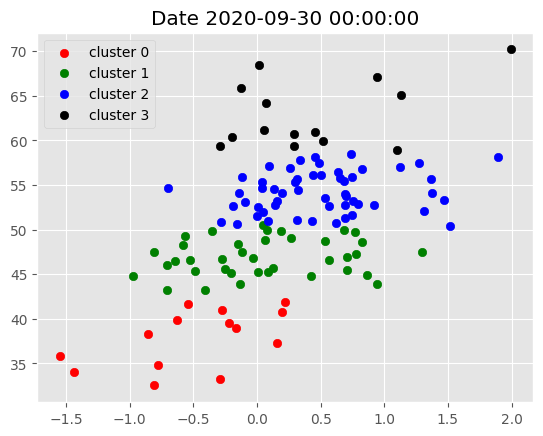

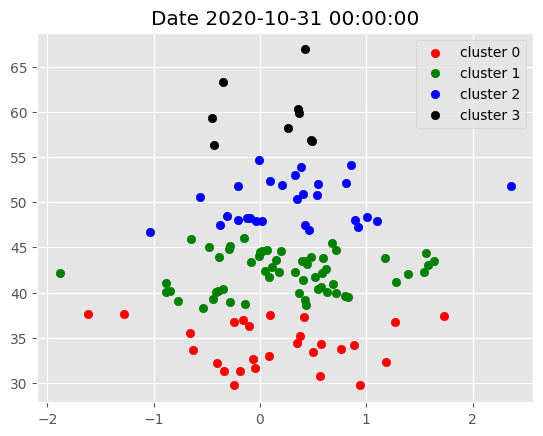

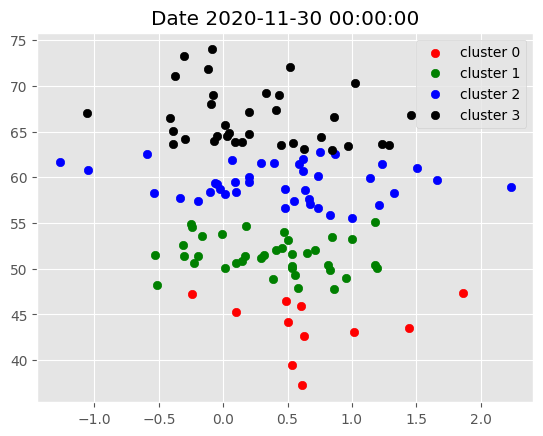

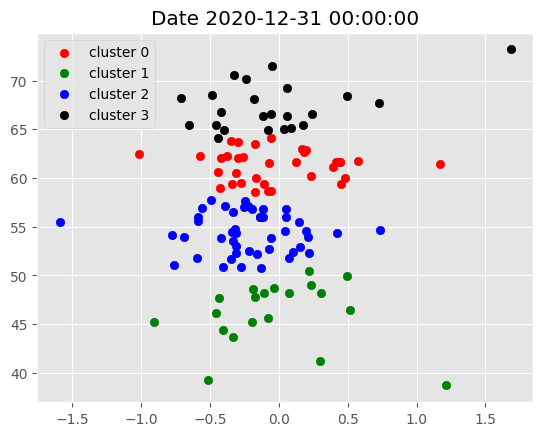

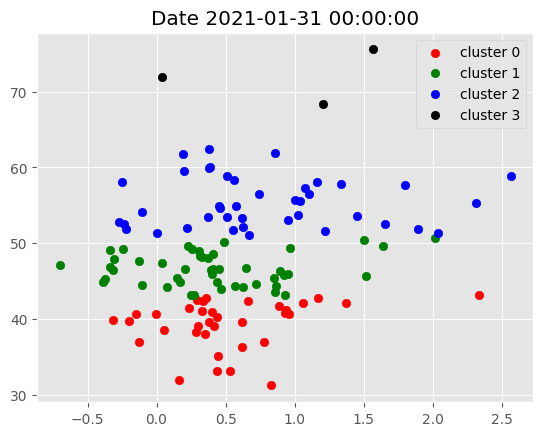

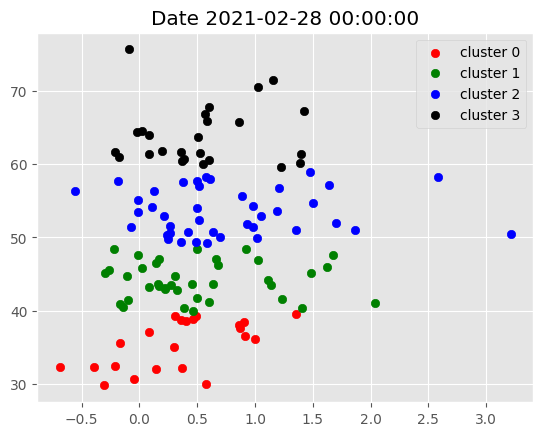

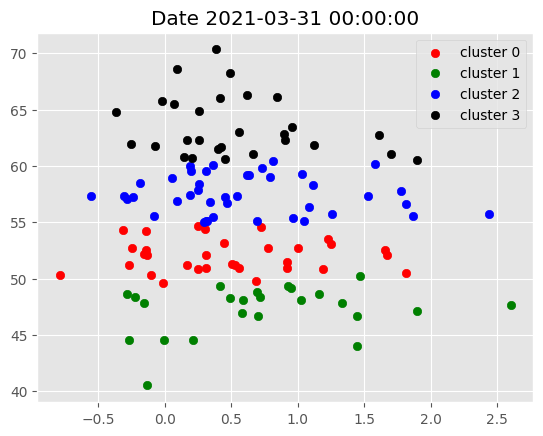

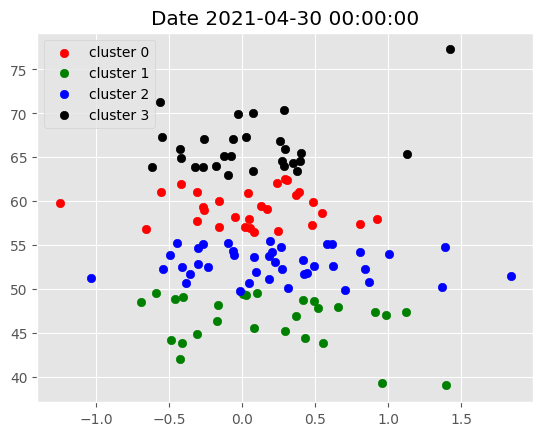

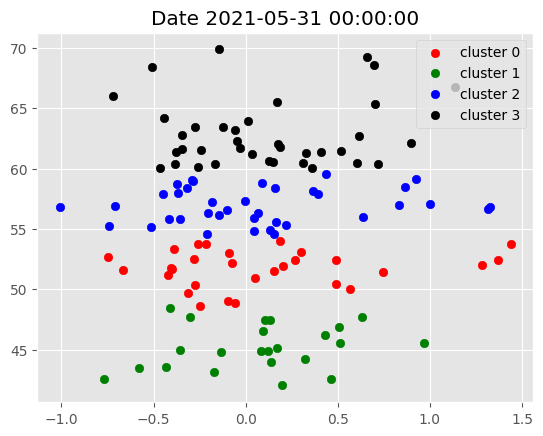

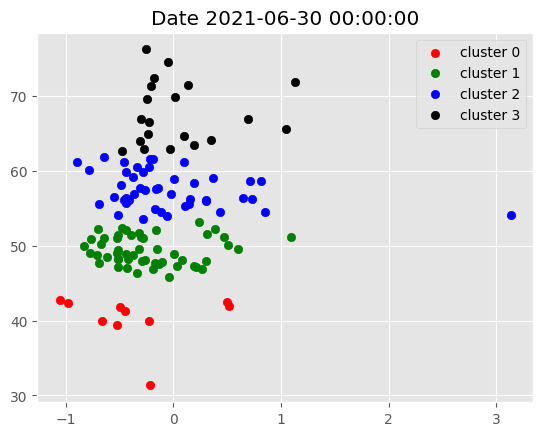

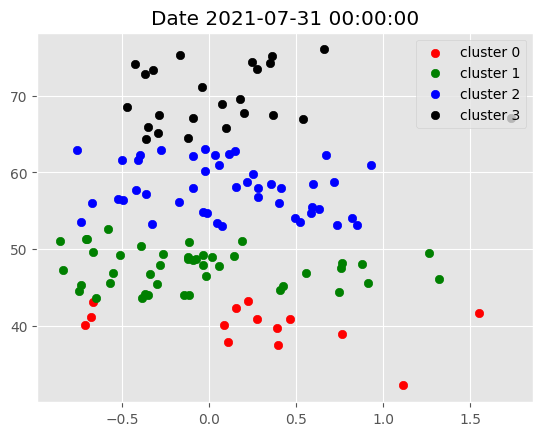

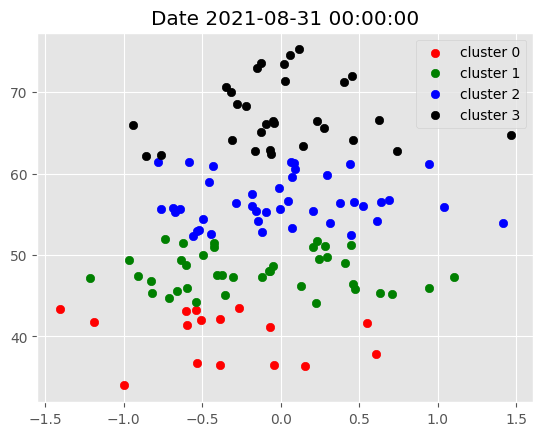

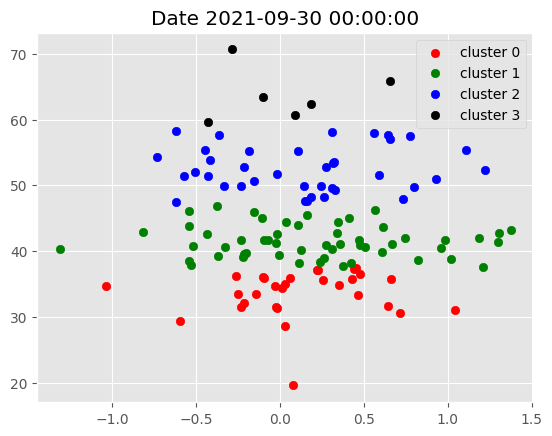

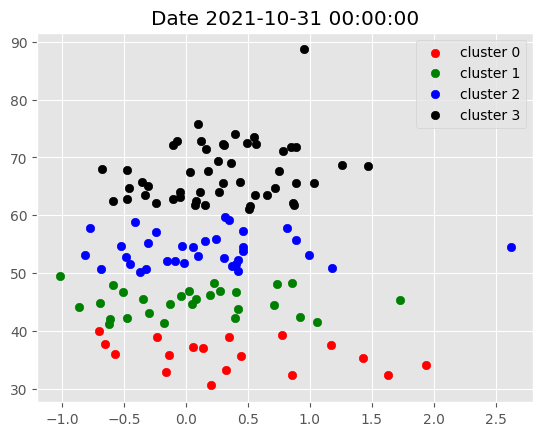

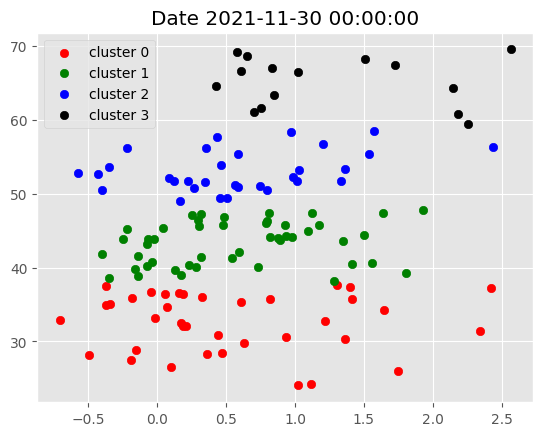

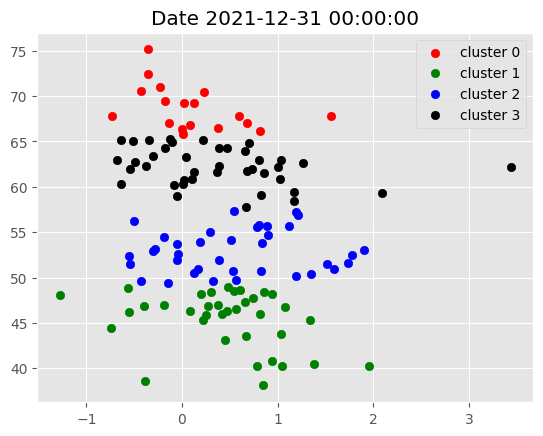

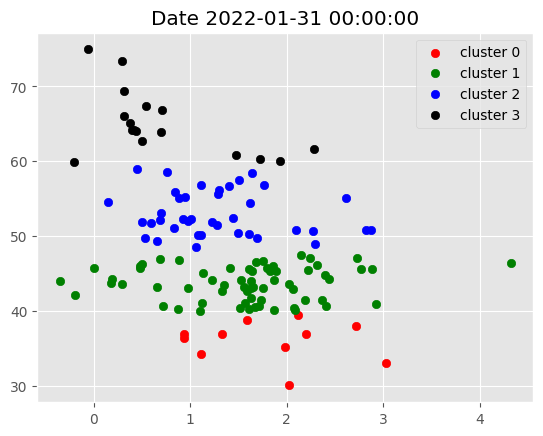

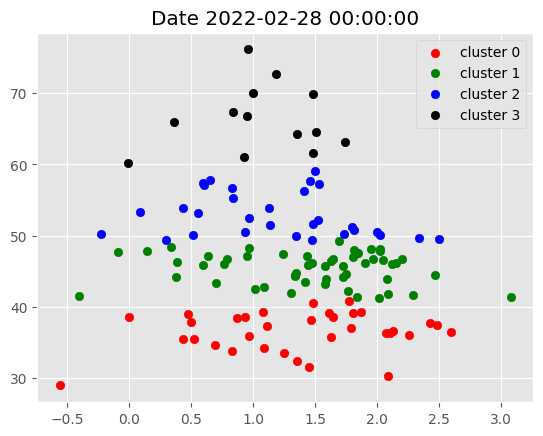

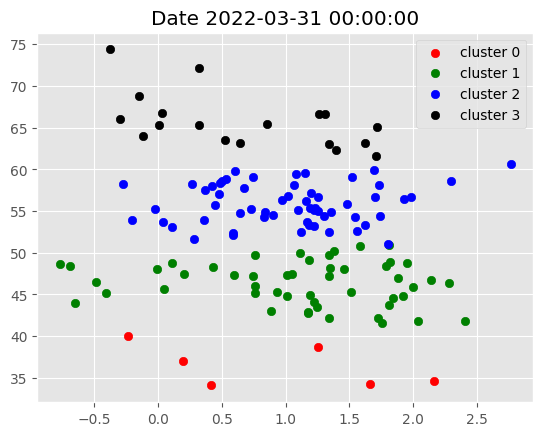

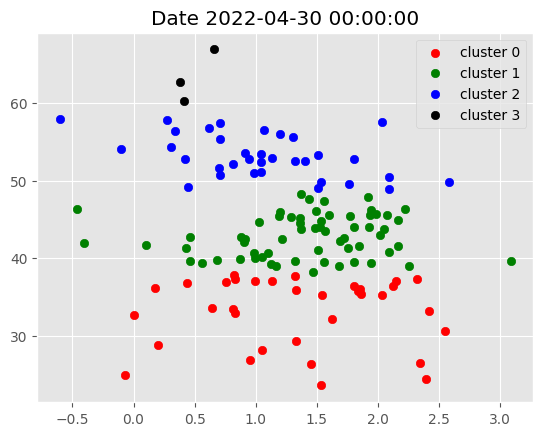

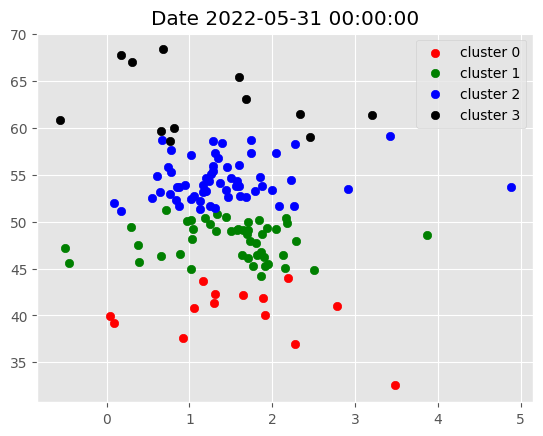

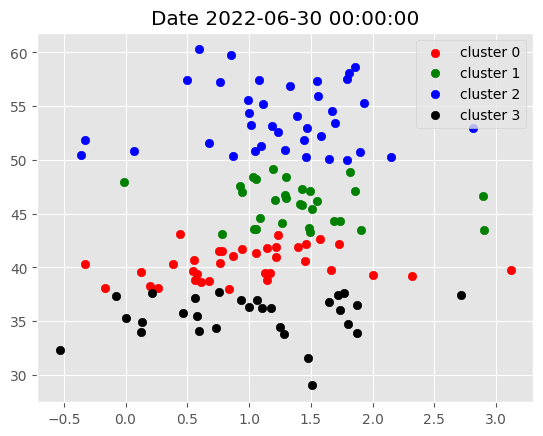

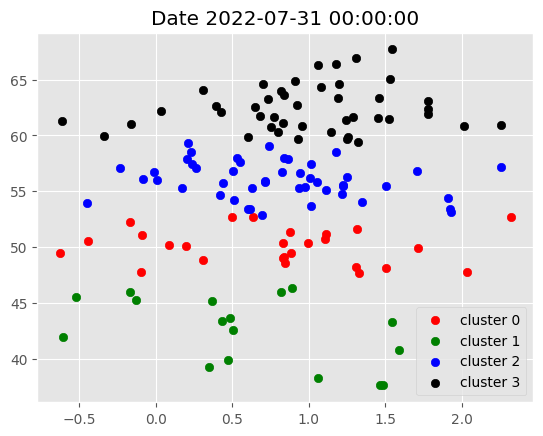

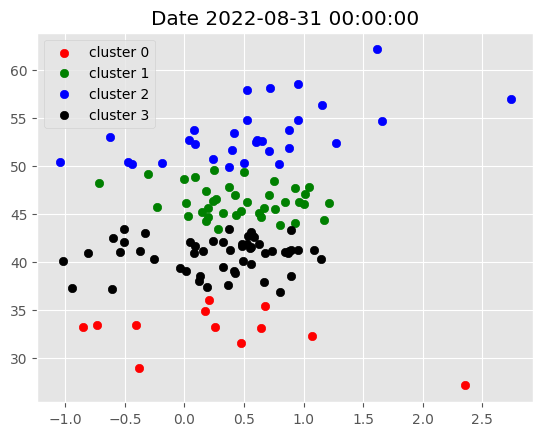

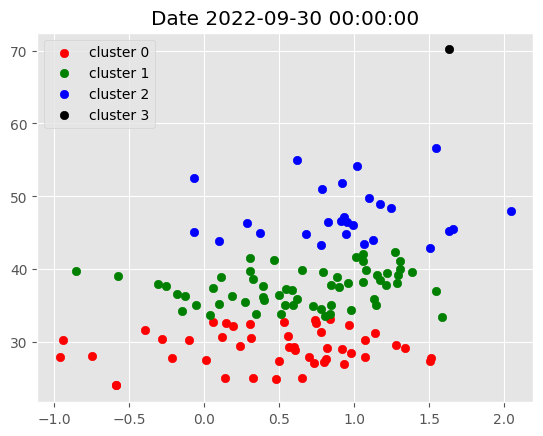

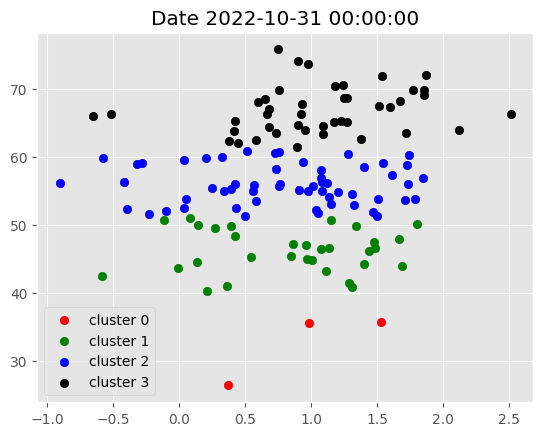

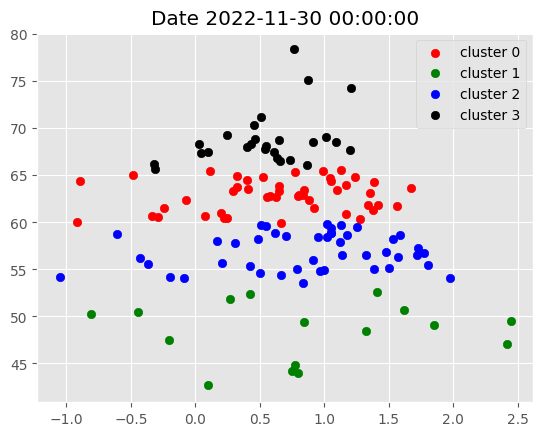

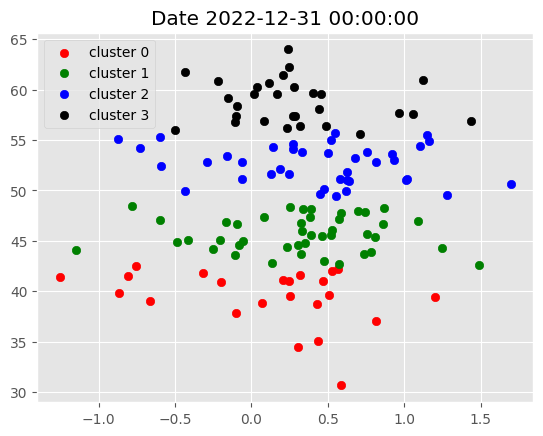

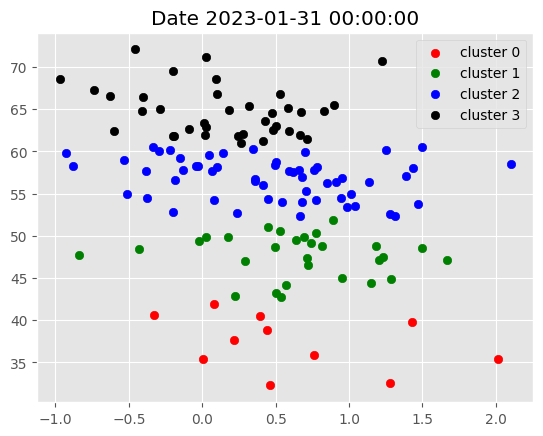

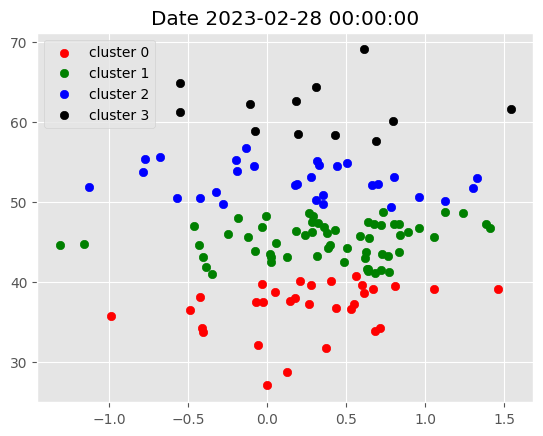

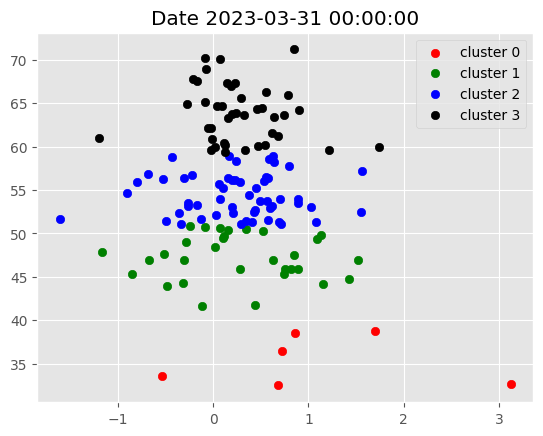

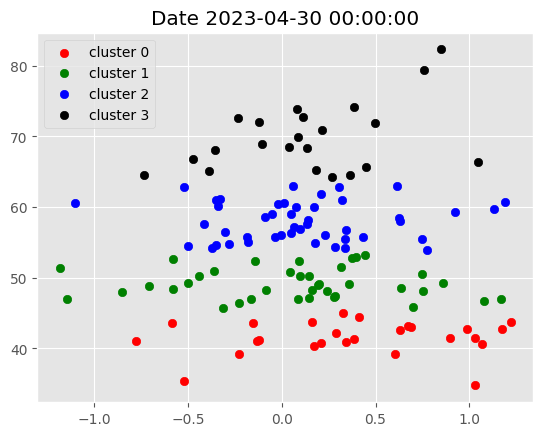

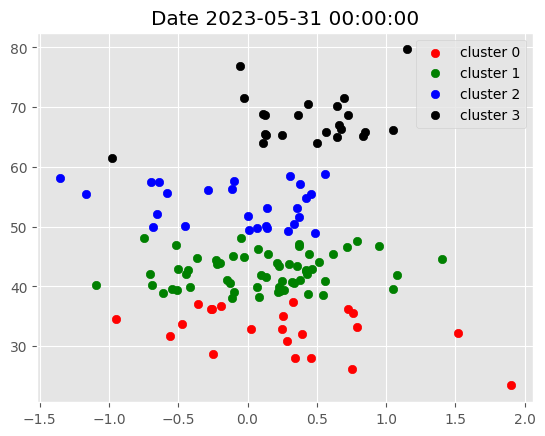

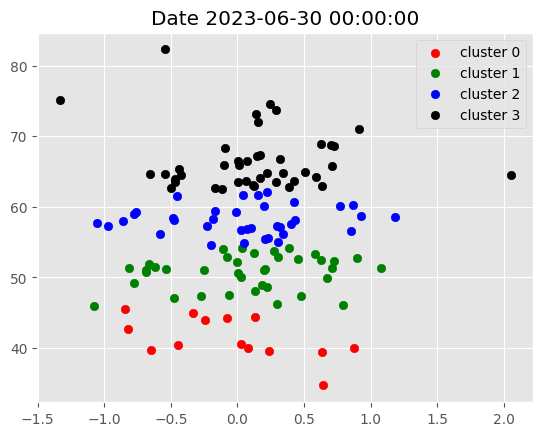

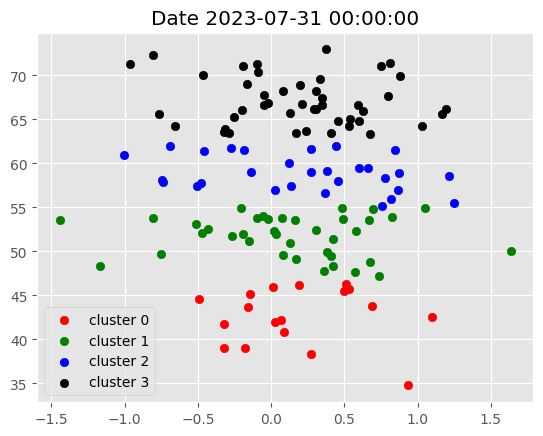

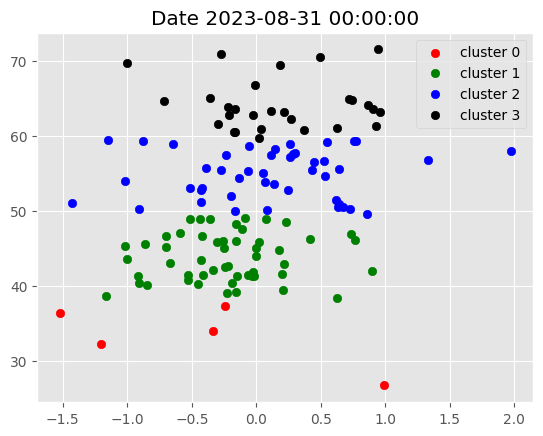

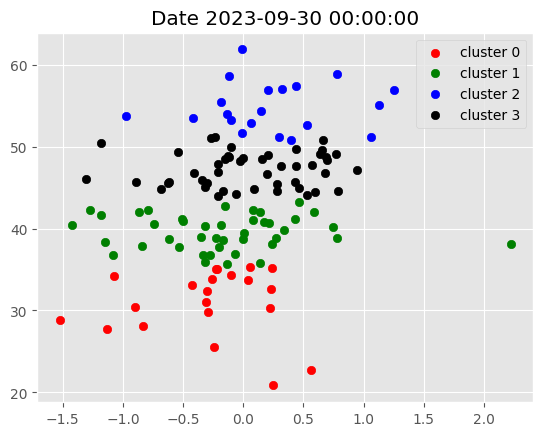

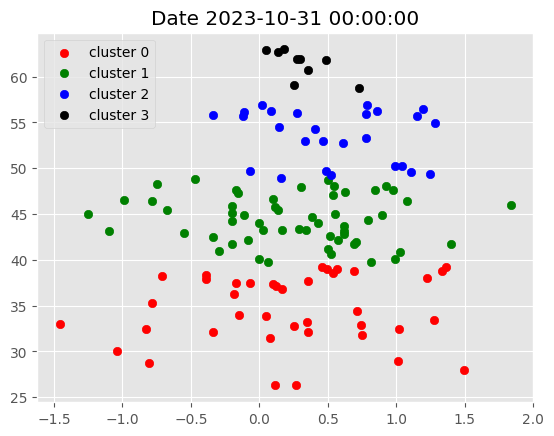

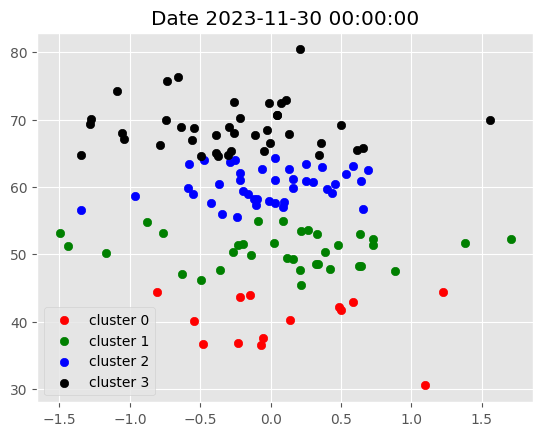

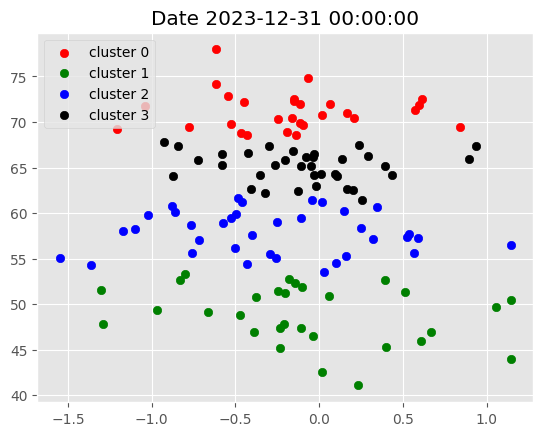

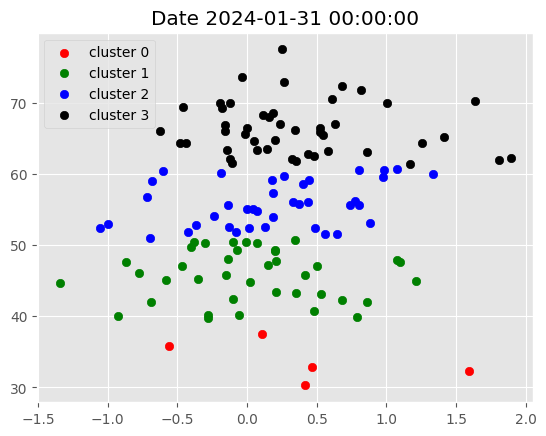

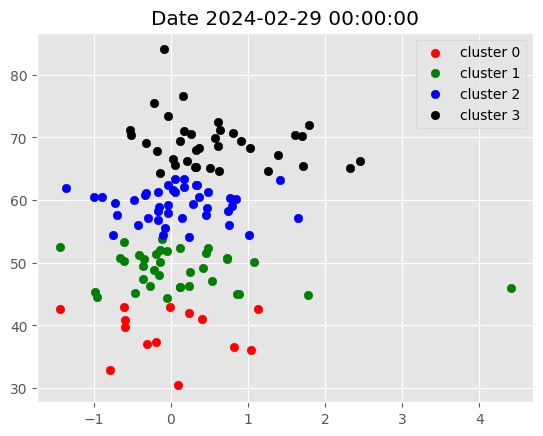

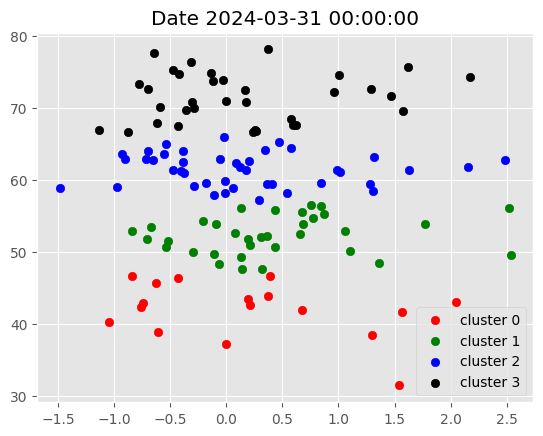

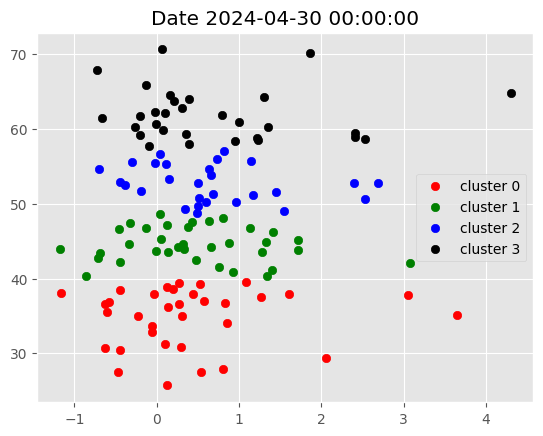

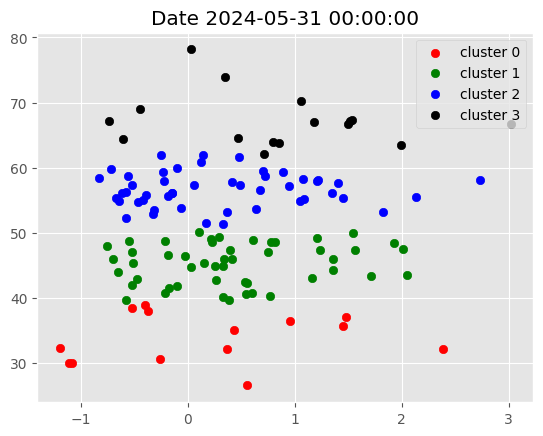

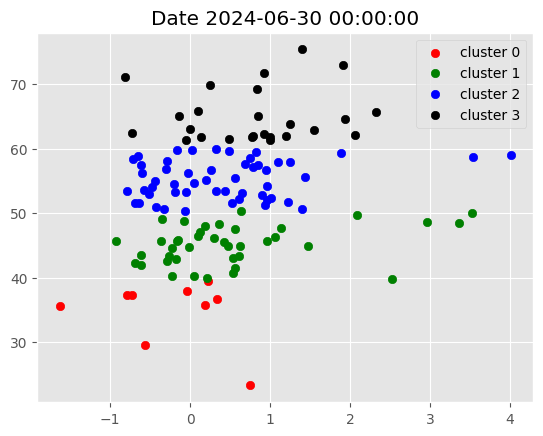

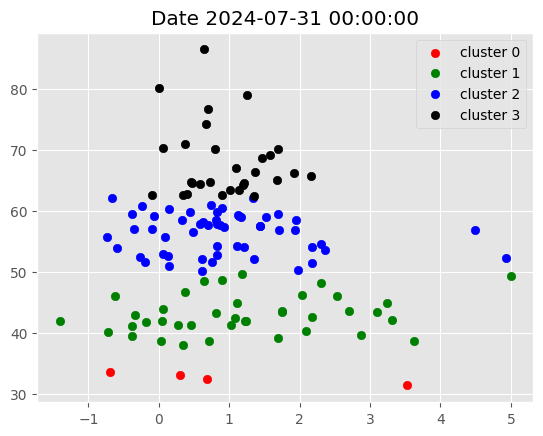

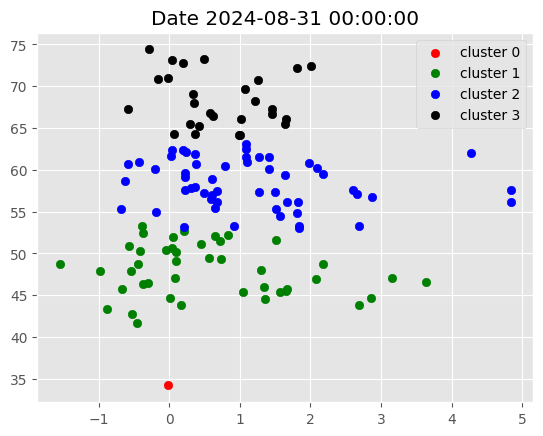

In [24]:
plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():
    
    g = data.xs(i, level=0)
    
    plt.title(f'Date {i}')
    
    plot_clusters(g)

### Apply pre-defined centroids.

In [17]:
target_rsi_values = [30, 45, 55, 70]

initial_centroids = np.zeros((len(target_rsi_values), 18))

initial_centroids[:, 6] = target_rsi_values

initial_centroids

array([[ 0.,  0.,  0.,  0.,  0.,  0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 45.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 55.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 70.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.]])

## 7. For each month select assets based on the cluster and form a portfolio based on Efficient Frontier max sharpe ratio optimization

* First we will filter only stocks corresponding to the cluster we choose based on our hypothesis.

* Momentum is persistent and my idea would be that stocks clustered around RSI 70 centroid should continue to outperform in the following month - thus I would select stocks corresponding to cluster 3.

In [25]:
filtered_df = data[data['cluster']==3].copy()

filtered_df = filtered_df.reset_index(level=1)

filtered_df.index = filtered_df.index+pd.DateOffset(1)

filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])

dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}

for d in dates:
    
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()
    
fixed_dates

{'2020-10-01': ['ABT',
  'AVGO',
  'COST',
  'DE',
  'DG',
  'DHR',
  'FDX',
  'MCD',
  'NKE',
  'NVDA',
  'PG',
  'TGT',
  'TMO',
  'UPS'],
 '2020-11-01': ['ADP', 'DHR', 'F', 'GE', 'GM', 'GOOG', 'GOOGL', 'SCHW', 'TMO'],
 '2020-12-01': ['ABBV',
  'ADI',
  'ADP',
  'ADSK',
  'AMAT',
  'AMD',
  'AVGO',
  'BA',
  'C',
  'CL',
  'COST',
  'CSCO',
  'DAL',
  'DE',
  'DIS',
  'DLTR',
  'F',
  'GE',
  'GM',
  'GS',
  'HON',
  'LRCX',
  'MS',
  'MU',
  'NKE',
  'NXPI',
  'OXY',
  'PANW',
  'PFE',
  'SBUX',
  'SCHW',
  'TGT',
  'TMUS',
  'TSLA',
  'WMT'],
 '2021-01-01': ['ADI',
  'ADSK',
  'AVGO',
  'BAC',
  'BKNG',
  'C',
  'DD',
  'DIS',
  'EA',
  'GS',
  'ISRG',
  'JNJ',
  'JPM',
  'LLY',
  'MS',
  'MU',
  'ORCL',
  'PANW',
  'SBUX',
  'SCHW',
  'TMUS',
  'TSLA',
  'WDC'],
 '2021-02-01': ['ABT', 'LLY', 'WBA'],
 '2021-03-01': ['AAL',
  'AMAT',
  'AXP',
  'BAC',
  'CAT',
  'COP',
  'CVX',
  'DAL',
  'DE',
  'F',
  'GE',
  'GS',
  'JPM',
  'LLY',
  'LUV',
  'MS',
  'MU',
  'OXY',
  'SBUX',
  'S

### Define portfolio optimization function

* We will define a function which optimizes portfolio weights using PyPortfolioOpt package and EfficientFrontier optimizer to maximize the sharpe ratio.

* To optimize the weights of a given portfolio we would need to supply last 1 year prices to the function.

* Apply single stock weight bounds constraint for diversification (minimum half of equaly weight and maximum 10% of portfolio).

In [26]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

# diversification purposes
#use lower_bound to dynamically diversify
def optimize_weights(prices, lower_bound=0):
    
    # calculate the returns of given stocks.
    returns = expected_returns.mean_historical_return(prices=prices,
                                                      frequency=252) # 1 year trading data.
    
    cov = risk_models.sample_cov(prices=prices,
                                 frequency=252)
    
    ef = EfficientFrontier(expected_returns=returns,
                           cov_matrix=cov,
                           weight_bounds=(lower_bound, .1),
                           solver='SCS')
    
    weights = ef.max_sharpe()
    
    return ef.clean_weights()


* Download Fresh Daily Prices Data only for short listed stocks.

In [27]:
stocks = data.index.get_level_values('ticker').unique().tolist()

new_df = yf.download(tickers=stocks,
                     start=data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12),
                     end=data.index.get_level_values('date').unique()[-1])

new_df

# 1 year prior to the main dataframe to get the optimize weights of given portfolio.


[*********************100%%**********************]  136 of 136 completed


Price       Adj Close                                                  \
Ticker            AAL        AAPL        ABBV         ABT         ACN   
Date                                                                    
2019-09-30  26.783880   54.180813   60.707130   76.737572  178.684280   
2019-10-01  26.615053   54.330795   58.710823   75.059212  176.148224   
2019-10-02  25.194921   52.968830   57.828911   72.940598  171.717117   
2019-10-03  25.095612   53.418789   59.207886   74.353004  172.608917   
2019-10-04  25.651747   54.916218   59.857296   75.196762  176.166794   
...               ...         ...         ...         ...         ...   
2024-08-26  10.210000  227.179993  197.440002  112.699997  336.779999   
2024-08-27  10.170000  228.029999  195.919998  113.099998  340.380005   
2024-08-28  10.150000  226.490005  195.399994  112.900002  337.390015   
2024-08-29  10.390000  229.789993  195.179993  112.760002  340.209991   
2024-08-30  10.620000  229.000000  196.309998  113.269997  341.950012   

Price                                                                   ...  \
Ticker            ADBE         ADI         ADP        ADSK        ALGN  ...   
Date                                                                    ...   
2019-09-30  276.250000  102.321373  145.892044  147.699997  180.919998  ...   
2019-10-01  272.709991  100.535583  144.997253  145.710007  182.300003  ...   
2019-10-02  266.660004   99.793800  141.553772  142.839996  179.750000  ...   
2019-10-03  272.399994  101.533806  142.385284  144.770004  184.770004  ...   
2019-10-04  276.959991  103.511902  143.858475  146.889999  181.589996  ...   
...                ...         ...         ...         ...         ...  ...   
2024-08-26  559.440002  225.610001  271.350006  256.209991  231.649994  ...   
2024-08-27  567.820007  231.839996  274.679993  256.989990  236.279999  ...   
2024-08-28  560.539978  227.169998  272.679993  254.619995  230.929993  ...   
2024-08-29  569.630005  230.889999  273.359985  258.230011  235.149994  ...   
2024-08-30  574.409973  234.839996  275.910004  258.399994  237.220001  ...   

Price         Volume                                                           \
Ticker           USB         V      VLO     VRTX        VZ       WBA      WDC   
Date                                                                            
2019-09-30   4403900  16464000  2899600  1432300   9709400   3218300  3799400   
2019-10-01   5620300   8146200  3193700   950800   8381600   4824700  3177100   
2019-10-02   5346800  10596200  2785300  1486100  12011700   5016000  5590700   
2019-10-03   4134700   7242800  2430500  1094000   9769300   3625100  4083100   
2019-10-04   3657800   6027600  2066600   873400   9824900   3895400  2415300   
...              ...       ...      ...      ...       ...       ...      ...   
2024-08-26   5849800   4612200  2752200   877600  10309500  15856600  3247200   
2024-08-27   5458000   6594100  2030300  1062200   9778200  45243600  5045700   
2024-08-28   6213900   5455100  2139700   942200  12732700  24787100  4673100   
2024-08-29   7064700   5565100  2275000   706700  17338100  24711900  4321200   
2024-08-30  14261300   6295400  3359500  1809700  20007000  19550400  6416200   

Price                                     
Ticker           WFC       WMT       XOM  
Date                                      
2019-09-30  26897100  10204200   9768900  
2019-10-01  27249300  11187900  10279100  
2019-10-02  23515900  17833500  14503700  
2019-10-03  20212200  15619500  10788400  
2019-10-04  15779500  13881000  10534800  
...              ...       ...       ...  
2024-08-26   9478800   9508200  13671000  
2024-08-27   7638500  11557800   9991600  
2024-08-28  11905200   9814300  10742900  
2024-08-29   9283300  11856800  10753900  
2024-08-30  20376600  23224500  13284200  

[1239 rows x 816 columns]

* Calculate daily returns for each stock which could land up in our portfolio.

* Then loop over each month start, select the stocks for the month and calculate their weights for the next month.

* If the maximum sharpe ratio optimization fails for a given month, apply equally-weighted weights.

* Calculated each day portfolio return.

In [28]:
returns_dataframe = np.log(new_df['Adj Close']).diff()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
    
    try:

        end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')

        cols = fixed_dates[start_date]

        optimization_start_date = (pd.to_datetime(start_date)-pd.DateOffset(months=12)).strftime('%Y-%m-%d')

        optimization_end_date = (pd.to_datetime(start_date)-pd.DateOffset(days=1)).strftime('%Y-%m-%d')


        # optimization_df = new_df[optimization_start_date:optimization_end_date]['Adj Close'][cols]
        # Code above are now deprecated because new pandas update on multi-level indexing.
        
        # To fix this, we manually indexing each one by one. First, select the date range
        date_range_df = new_df.loc[optimization_start_date:optimization_end_date]

        # Then, select the 'Adj Close' column
        adj_close_df = date_range_df['Adj Close']
        
        # Finally, select the specific columns (tickers) you want
        optimization_df = adj_close_df[cols]
        
        success = False
        try:
            weights = optimize_weights(prices=optimization_df,
                                   lower_bound=round(1/(len(optimization_df.columns)*2),3))

            weights = pd.DataFrame(weights, index=pd.Series(0))
            
            success = True
        except:
            print(f'Max Sharpe Optimization failed for {start_date}, Continuing with Equal-Weights')
        
        if success==False:
            weights = pd.DataFrame([1/len(optimization_df.columns) for i in range(len(optimization_df.columns))],
                                     index=optimization_df.columns.tolist(),
                                     columns=pd.Series(0)).T
        
        temp_df = returns_dataframe[start_date:end_date]

        temp_df = temp_df.stack().to_frame('return').reset_index(level=0)\
                   .merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True),
                          left_index=True,
                          right_index=True)\
                   .reset_index().set_index(['Date', 'Ticker']).unstack().stack()

        temp_df.index.names = ['date', 'ticker']

        temp_df['weighted_return'] = temp_df['return']*temp_df['weight']

        temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy Return')

        portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)
    
    except Exception as e:
        print(e)

portfolio_df = portfolio_df.drop_duplicates()

portfolio_df

Max Sharpe Optimization failed for 2020-11-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2021-02-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2021-10-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2022-05-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2022-07-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2022-09-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2022-10-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2023-11-01, Continuing with Equal-Weights
'return'


,Strategy Return
date,
2020-10-01,0.003973
2020-10-02,-0.007086
2020-10-05,0.019937
2020-10-06,-0.004147
2020-10-07,0.017861
...,...
2024-08-26,0.003815
2024-08-27,0.002806
2024-08-28,0.002690


## 8. Visualize Portfolio returns and compare to SP500 returns.

In [29]:
spy = yf.download(tickers='SPY',
                  start='2015-01-01',
                  end=dt.date.today())

spy_ret = np.log(spy[['Adj Close']]).diff().dropna().rename({'Adj Close':'SPY Buy&Hold'}, axis=1)

portfolio_df = portfolio_df.merge(spy_ret,
                                  left_index=True,
                                  right_index=True)

portfolio_df

[*********************100%%**********************]  1 of 1 completed


,Strategy Return,SPY Buy&Hold
2020-10-01,0.003973,0.006399
2020-10-02,-0.007086,-0.009540
2020-10-05,0.019937,0.017578
2020-10-06,-0.004147,-0.014318
2020-10-07,0.017861,0.017257
...,...,...
2024-08-26,0.003815,-0.002387
2024-08-27,0.002806,0.001372
2024-08-28,0.002690,-0.005822
2024-08-29,0.005427,0.000090


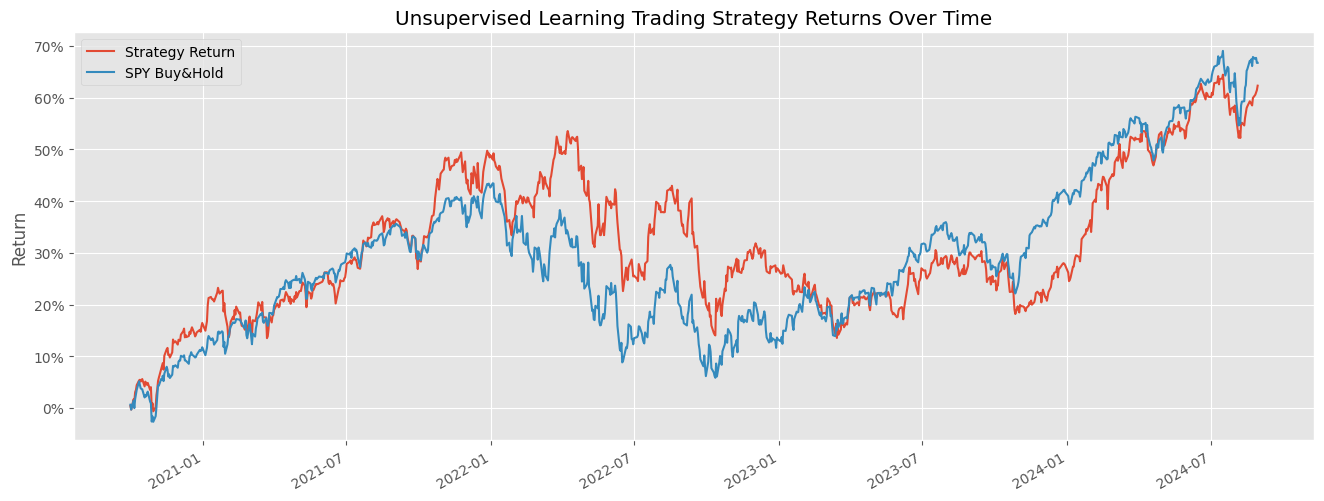

In [30]:
import matplotlib.ticker as mtick

plt.style.use('ggplot')

portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum())-1

portfolio_cumulative_return[:'2024-08-29'].plot(figsize=(16,6))

plt.title('Unsupervised Learning Trading Strategy Returns Over Time')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()